# MNIST dataset classification

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import os
import numpy as np
import scipy as sp
import wget
import gzip

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.externals import joblib

np.random.seed(42)

d:\projects\monitoria\image-classifier\venv\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Fetching the data

In [4]:
wget.download('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
wget.download('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
wget.download('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
wget.download('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')

100% [................................................................................] 4542 / 4542

't10k-labels-idx1-ubyte.gz'

## Loading the data to Numpy arrays

In [5]:
with gzip.open("train-images-idx3-ubyte.gz", "rb") as f:
    X = np.frombuffer(f.read(), dtype=np.uint8, offset=16).copy()
    X = X.reshape((60000, 28*28))

In [6]:
with gzip.open("train-labels-idx1-ubyte.gz", "rb") as f:
    y = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

## Visualizing 64 random images

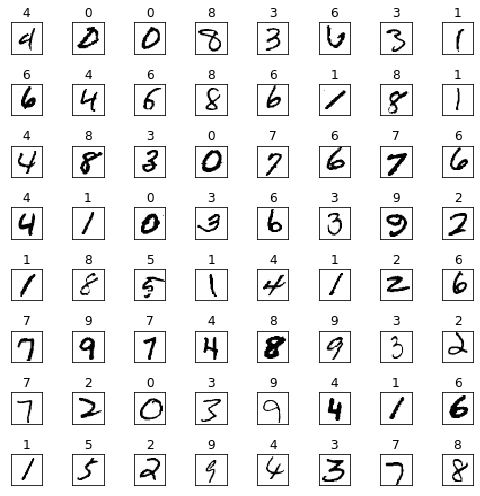

In [7]:
ind = np.random.randint(0, 60000, 64)
X_vis = X[ind, :].reshape(64, 28, 28) 
y_vis = y[ind]
plt.figure(figsize=(7, 7))
for i in range(1,9):
    for j in range(1, 9):
        plt.subplot(8, 8, (i-1)*8+j)
        plt.imshow(X_vis[(i-1)*8+j-1], cmap=plt.cm.Greys)
        plt.gca().xaxis.set_ticks([])
        plt.gca().yaxis.set_ticks([])
        plt.title(y_vis[(i-1)*8+j-1])
        
plt.tight_layout()
plt.show()

## Splitting the dataset. Making training and validation sets

In [8]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
indx = sss.split(X, y)

for train_index, val_index in indx:
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

In [9]:
print('Training data: ', X_train.shape, y_train.shape)
print('Test data: ', X_train.shape, y_train.shape)

Training data:  (42000, 784) (42000,)
Test data:  (42000, 784) (42000,)


In [10]:
clf = RandomForestClassifier(n_estimators=10, criterion='entropy', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
print('Accuracy is', sum(y_val == clf.predict(X_val))/1./y_val.shape[0], '%')

Accuracy is 0.9430555555555555 %


In [11]:
scores = []
trees =  [5, 10, 20, 30, 40, 50, 60, 100, 300]
for n_trees in trees:
    clf = RandomForestClassifier(n_estimators=n_trees, n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    scores.append(100*sum(y_val == clf.predict(X_val))/1./y_val.shape[0])

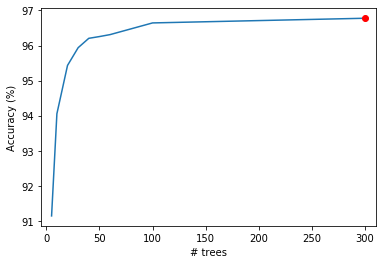

In [12]:
plt.figure()
plt.plot(trees, scores)
plt.plot([trees[np.argmax(scores)]], [max(scores)], 'ro')
plt.xlabel('# trees')
plt.ylabel('Accuracy (%)')
plt.xlim(min(trees)-10, max(trees)+10)
plt.show()

In [13]:
print('Best number of trees:', trees[np.argmax(scores)])
print('Best score: ', max(scores))

Best number of trees: 300
Best score:  96.77777777777777


## Retraining the classifier on the whole dataset and testing

In [14]:
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Getting the MNIST test data

In [15]:
with gzip.open("t10k-images-idx3-ubyte.gz", "rb") as f:
    X_test = np.frombuffer(f.read(), dtype=np.uint8, offset=16).copy()  
    X_test = X_test.reshape((10000, 28*28))
    
with gzip.open("t10k-labels-idx1-ubyte.gz", "rb") as f:
    y_test = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

In [16]:
print('Accuracy on the TEST set is', 100*sum(y_test == clf.predict(X_test))/1./y_test.shape[0], '%')

Accuracy on the TEST set is 97.15 %


Let us now retrain the classifier on the whole dataset in order to learn more variability in the data

In [ ]:
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
clf.fit(np.vstack((X, X_test)), np.hstack((y,y_test)))

## "Pickling" the trained classifier

Pickle mechanism has some security issues, so, carefully read the instructions on the scikit-learn web-site

In [ ]:
joblib.dump(clf, 'digits_classifier/clf.pkl')